In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.patches as mpatches
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## Loading data

In [2]:
# writing a function that loads file, read and append to training data

def load_file_from_csv(input_csv_file):
    # initializing lists
    messages = []
    labels = []
    #loading file
    file = open(input_csv_file, "r")
    #read files line by line
    lines = file.readlines()
    #looping through the lines of text
    for line in lines:
        #split message by tab
        parts = line.split("\t")
        if len(parts) >= 2:
            # attach first column to label
            label = parts[0]
            # attach second column to message and remove any whitespace
            message = parts[1].strip()
            # checks that message is not a number or digit or empty
            if label and message and not message.isdigit() and message not in messages:
                # attaches label to labels and message to messages
                labels.append(label)
                messages.append(message)
    # Remove duplicate messages using set()
    messages = list(set(messages))
    # function output
    return messages, labels

## Data Exploration

In [3]:
messages, labels = load_file_from_csv("C:/Users/ritac/Documents/Datasets/smsspamdataset.training.csv")
print(len(labels), len(messages))

2846 2846


In [4]:
data = pd.DataFrame({"Labels":labels, "Messages":messages})
data.head()

,Labels,Messages
0,0,"Yeah, probably but not sure. Ilol let u know, ..."
1,0,"Greetings me, ! Consider yourself excused."
2,1,Ffffffffff. Alright no way I can meet up with ...
3,0,Good Morning my Dear........... Have a great &...
4,0,K.:)do it at evening da:)urgent:)


In [5]:
label_counts = data["Labels"].value_counts()
label_counts

0    2468
1     378
Name: Labels, dtype: int64

In [6]:
#generating wordcloud
def generate_word_cloud(data_frame, message_column, label_column):
    # mapping labels to names
    label_mapping = {"0": "Ham", "1": "Spam"}
    #extracting unique labels from the label column 
    unique_label = data_frame[label_column].unique()
    for label in unique_label:
        mapped_label = label_mapping[label]
        unique_messages = data_frame[data_frame[label_column] == label][message_column]
        unique_text = " ".join(list(unique_messages))
    
        # generating wordcloud
        wordcloud = WordCloud(height=800, width=800, background_color="black").generate(unique_text)
    
        # plotting wordcloud
        plt.figure(figsize=(5, 8))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title(f"Wordcloud of {mapped_label} messages")
        plt.axis("off")
        plt.show()

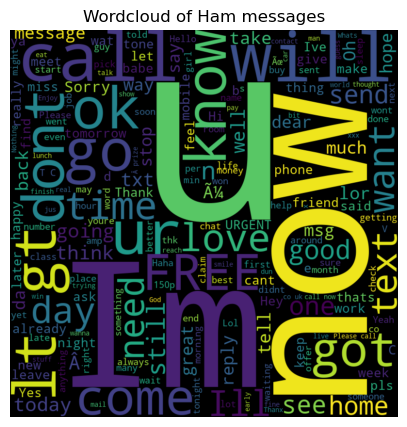

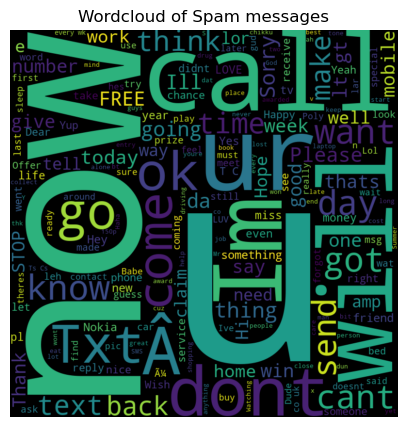

In [7]:
generate_word_cloud(data, "Messages", "Labels")

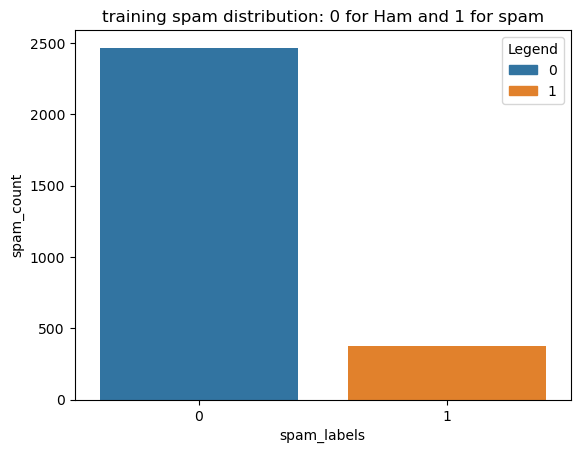

In [8]:
#setting plots
ax = sns.barplot(data, x=label_counts.index, y=label_counts.values)
plt.title("training spam distribution: 0 for Ham and 1 for spam")
plt.xlabel("spam_labels")
plt.ylabel("spam_count")

# Create legend handles and labels
legend_handles = [mpatches.Patch(color=ax.patches[i].get_facecolor(), 
                                 label=label_counts.index[i]) for i in range(len(ax.patches))]

# Add legend
plt.legend(handles=legend_handles, title="Legend")
#display plot
plt.show()


In [9]:
test_messages, test_labels = load_file_from_csv('C:/Users/ritac/Documents/Datasets/smsspamdataset.test.csv')
print(len(test_messages), len(test_labels))

2483 2483


In [10]:
data2 = pd.DataFrame({"Labels":test_labels, "Messages":test_messages})
test_label_counts = data["Labels"].value_counts()
label_counts

0    2468
1     378
Name: Labels, dtype: int64

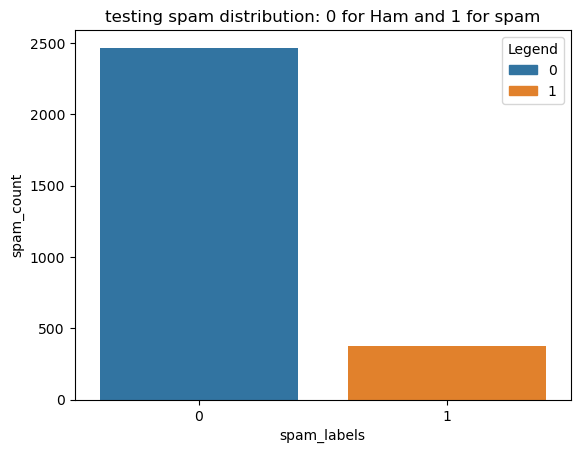

In [11]:
#setting plots
ax = sns.barplot(data2, x=test_label_counts.index, y=test_label_counts.values)
plt.title("testing spam distribution: 0 for Ham and 1 for spam")
plt.xlabel("spam_labels")
plt.ylabel("spam_count")

# Create legend handles and labels
legend_handles = [mpatches.Patch(color=ax.patches[i].get_facecolor(), 
                                 label=test_label_counts.index[i]) for i in range(len(ax.patches))]

# Add legend
plt.legend(handles=legend_handles, title="Legend")
#display plot
plt.show()

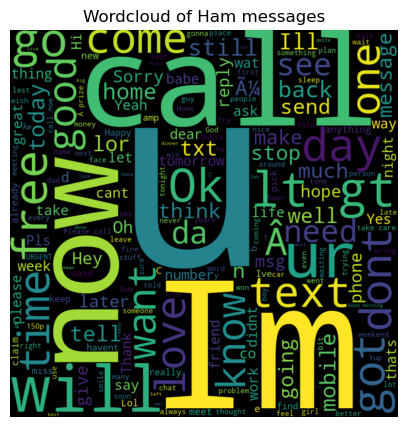

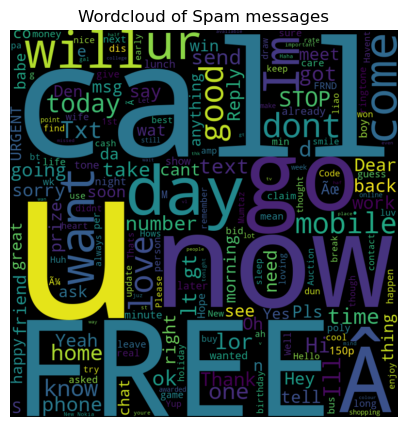

In [12]:
generate_word_cloud(data2, "Messages", "Labels")

## Splitting Datasets

In [13]:
training_messages, training_labels = load_file_from_csv("C:/Users/ritac/Documents/Datasets/smsspamdataset.training.csv")
testing_messages, testing_labels = load_file_from_csv('C:/Users/ritac/Documents/Datasets/smsspamdataset.test.csv')

## Feature Extraction

In [14]:
#training a CountVectorizer
training_count_vec = CountVectorizer(max_features=10000, stop_words="english")

#converting training messages to BOW features by using initialised countvectorizer on the training dataset
bow_training_messages = training_count_vec.fit_transform(training_messages)

#extracting generated features for training of testing dataset
bow_features = training_count_vec.get_feature_names_out()

#initialising a countvectorizer with extracted features
testing_count_vec = CountVectorizer(stop_words="english", vocabulary=bow_features)

#converting testing dataset using extracted BOW features
bow_testing_messages = testing_count_vec.fit_transform(testing_messages) 

In [15]:
#print(bow_training_messages)

## Training Models

In [16]:
# training the Decision tree model
DT_classifier = tree.DecisionTreeClassifier()

# fitting the model to the training messages and labels
DT_classifier.fit(bow_training_messages, training_labels)
print("training complete")

# generating models prediction
dt_pred = DT_classifier.predict(bow_testing_messages)
print(dt_pred)

training complete
['1' '0' '0' ... '0' '0' '0']


In [23]:
# Create a k-NN classifier with a specified number of neighbors (e.g., k=3)
knn_classifier = KNeighborsClassifier(n_neighbors=3)

# Train the classifier on the training data
knn_classifier.fit(bow_training_messages, training_labels)
print("training complete")

# Make predictions on the testing data
knn_pred = knn_classifier.predict(bow_testing_messages)
print(knn_pred)

training complete
['0' '0' '0' ... '0' '0' '0']


In [31]:
# Create a Gaussian Naive Bayes classifier
gnb_classifier = GaussianNB()

# Convert the sparse matrix to a dense numpy array
bow_training_messages_dense = bow_training_messages.toarray()
bow_testing_messages_dense = bow_testing_messages.toarray()

# Train the classifier on the training data
gnb_classifier.fit(bow_training_messages_dense, training_labels)
print("training complete")

# Make predictions on the testing data
gnb_pred = gnb_classifier.predict(bow_testing_messages_dense)
print(gnb_pred)

training complete
['0' '1' '1' ... '0' '0' '0']


In [28]:
# Create a Multinomial Naive Bayes classifier
mnb_classifier = MultinomialNB()

# Train the classifier on the training data
mnb_classifier.fit(bow_training_messages, training_labels)
print("training complete")

# Make predictions on the testing data
mnb_pred = mnb_classifier.predict(bow_testing_messages)
print(mnb_pred)

training complete
['0' '0' '0' ... '0' '0' '0']


## Evaluation of models predictions

In [18]:
print(classification_report(testing_labels, dt_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2166
           1       0.15      0.12      0.13       317

    accuracy                           0.80      2483
   macro avg       0.51      0.51      0.51      2483
weighted avg       0.78      0.80      0.79      2483



In [19]:
print(classification_report(testing_labels, knn_pred))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2166
           1       0.11      0.02      0.03       317

    accuracy                           0.86      2483
   macro avg       0.49      0.50      0.48      2483
weighted avg       0.77      0.86      0.81      2483



In [32]:
print(classification_report(testing_labels, gnb_pred))

              precision    recall  f1-score   support

           0       0.87      0.68      0.76      2166
           1       0.12      0.31      0.18       317

    accuracy                           0.63      2483
   macro avg       0.50      0.49      0.47      2483
weighted avg       0.77      0.63      0.69      2483



In [30]:
print(classification_report(testing_labels, mnb_pred))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93      2166
           1       0.19      0.02      0.03       317

    accuracy                           0.86      2483
   macro avg       0.53      0.50      0.48      2483
weighted avg       0.79      0.86      0.81      2483



## Visualizing Evaluation Reports

In [34]:
#plotting confusion matrix for each model
def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add counts to the cells
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()


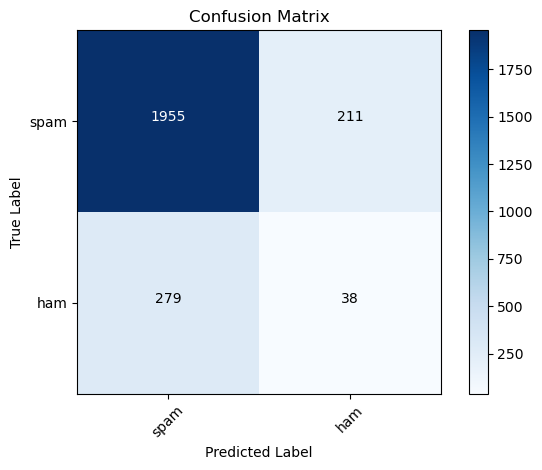

In [37]:
#  confusion matrix for Decision tree
classes = ['spam', 'ham']
plot_confusion_matrix(testing_labels, dt_pred, classes)

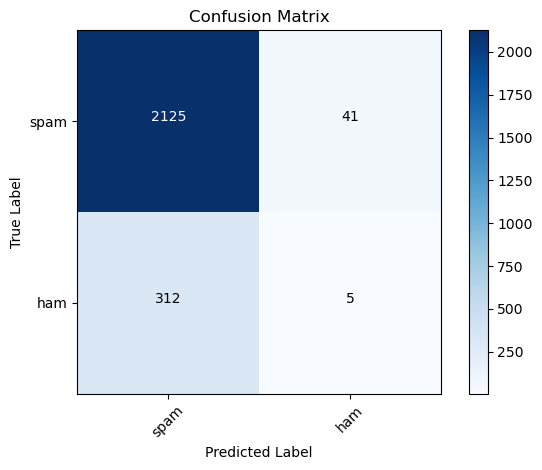

In [38]:
#  confusion matrix for k nearest neigbour
classes = ['spam', 'ham']
plot_confusion_matrix(testing_labels, knn_pred, classes)

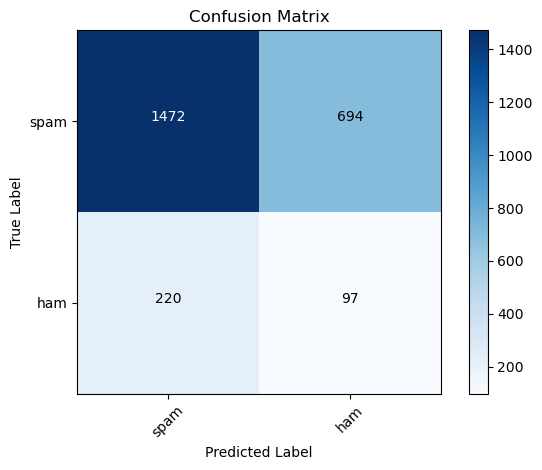

In [39]:
#  confusion matrix for gaussian naive bayes
classes = ['spam', 'ham']
plot_confusion_matrix(testing_labels, gnb_pred, classes)

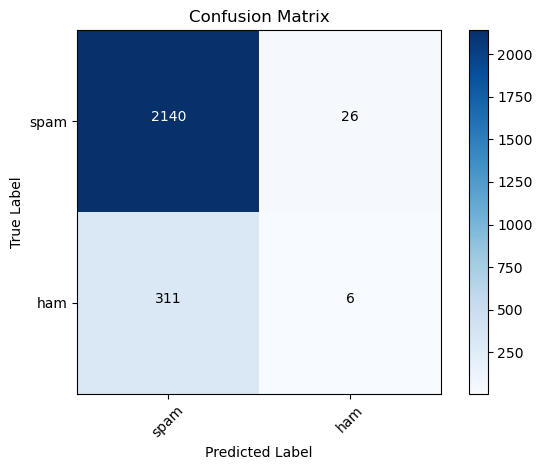

In [40]:
#  confusion matrix for multinomial naive bayes
classes = ['spam', 'ham']
plot_confusion_matrix(testing_labels, mnb_pred, classes)

In [54]:
def plot_clustered_column_chart(labels, data, xticks):
    num_labels = len(labels)
    num_xticks = len(xticks)

    # Check if the dimensions of labels and data match
    if num_labels != data.shape[0]:
        raise ValueError("Number of labels and data arrays do not match.")

    # Check if the dimensions of xticks and data match
    if num_xticks != data.shape[1]:
        raise ValueError("Number of xticks and data columns do not match.")

    # Set the width of each bar
    bar_width = 0.2

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Set the positions of the bars on the x-axis
    x_positions = np.arange(num_xticks)

    # Iterate over each label and plot the clustered bars
    for i in range(num_labels):
        ax.bar(x_positions + i * bar_width, data[i], width=bar_width, label=labels[i])

    # Set the xticks and xticklabels
    ax.set_xticks(x_positions + (num_labels - 1) * bar_width / 2)
    ax.set_xticklabels(xticks)

    # Add legend and labels
    ax.legend()
    ax.set_xlabel("Categories")
    ax.set_ylabel("Scores")

    # Show the plot
    plt.show()

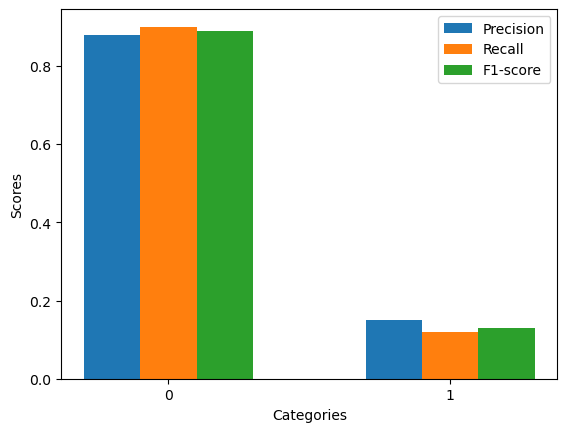

In [55]:
# Decision tree clustered column
labels = ['Precision', 'Recall', 'F1-score']
data = np.array([[0.88, 0.15], [0.90, 0.12], [0.89, 0.13]])
xticks = ['0', '1']

plot_clustered_column_chart(labels, data, xticks)

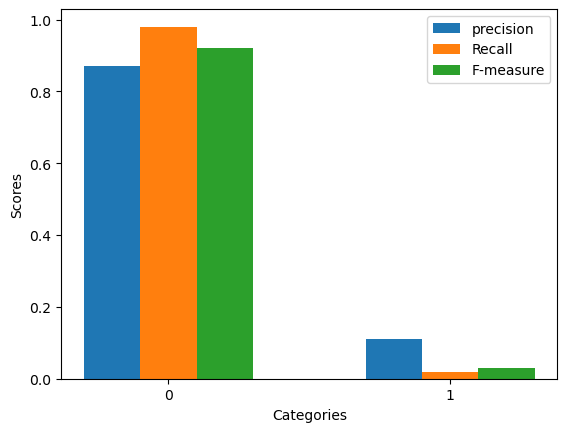

In [57]:
# k-nearest neighbour clustered column
labels = ['precision', 'Recall', 'F-measure']
data = np.array([[0.87, 0.11], [0.98, 0.02], [0.92, 0.03]])
xticks = ['0', '1']

plot_clustered_column_chart(labels, data, xticks)

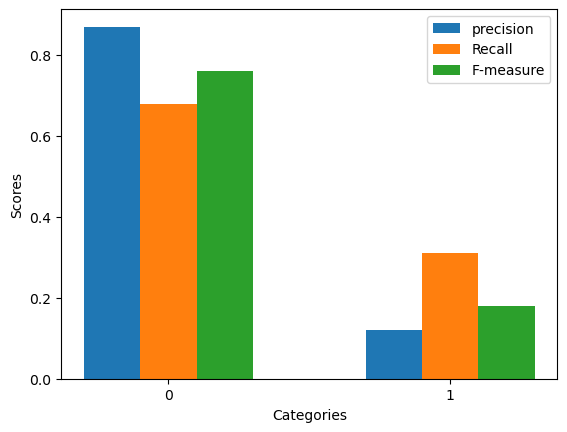

In [59]:
# gaussian naive bayes clustered column
labels = ['precision', 'Recall', 'F-measure']
data = np.array([[0.87, 0.12], [0.68, 0.31], [0.76, 0.18]])
xticks = ['0', '1']

plot_clustered_column_chart(labels, data, xticks)

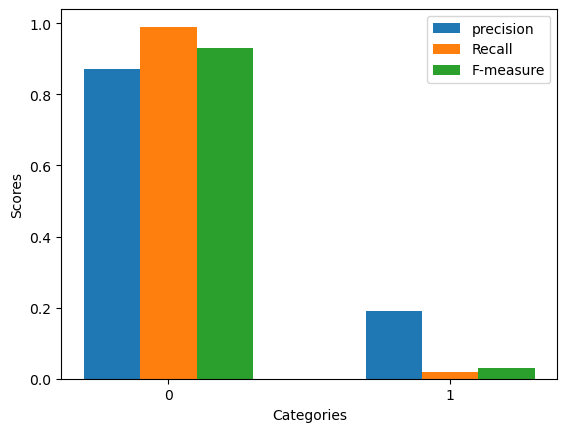

In [60]:
#multinomial naive bayes clustered column
labels = ['precision', 'Recall', 'F-measure']
data = np.array([[0.87, 0.19], [0.99, 0.02], [0.93, 0.03]])
xticks = ['0', '1']

plot_clustered_column_chart(labels, data, xticks)

## Accuracy Results

In [70]:
# accuracy of the Data
accuracy = accuracy_score(testing_labels, dt_pred)
accuracy_formatted = "{:.3f}".format(accuracy)
print("DT_Accuracy:", accuracy_formatted)

DT_Accuracy: 0.803


In [71]:
# accuracy of the Data
accuracy = accuracy_score(testing_labels, knn_pred)
accuracy_formatted = "{:.3f}".format(accuracy)
print("KNN_Accuracy:", accuracy_formatted)

KNN_Accuracy: 0.858


In [72]:
# accuracy of the Data
accuracy = accuracy_score(testing_labels, gnb_pred)
accuracy_formatted = "{:.3f}".format(accuracy)
print("GNB_Accuracy:", accuracy_formatted)

GNB_Accuracy: 0.632


In [75]:
# accuracy of the Data
accuracy = accuracy_score(testing_labels, mnb_pred)
accuracy_formatted = "{:.3f}".format(accuracy)
print("MNB_Accuracy:", accuracy_formatted)

MNB_Accuracy: 0.864


## Data Insights

### Multinomial Naive Bayes has the highest Accuracy, Recall and F1-score